In [1]:
''' plot wind power for around HU Lee's case & add TC tracks '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from mystats import bandpass
from values_to_colors import values_to_rgba, truncate_colormap
from convert_time import datetime_to_yearday
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [2]:
''' Wind power data file info '''
year = '2023'
n_f = [0.8,1.2]
lonlim = np.array([-80, -40])
latlim = np.array([10, 45])
tlim = [datetime.datetime(int(year),9,4), datetime.datetime(int(year),9,21)]
tlim_str = tlim[0].strftime('%Y%m%d')+'-'+tlim[1].strftime('%Y%m%d')
xylim_str = '{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])
path_wp = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/compute_wp/')
fn_data = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV({:.2f}f-{:.2f}f)_'.format(n_f[0],n_f[1])+tlim_str+'_'+xylim_str+'.nc'
''' Read data '''
ds_wp = nc.Dataset(path_wp + fn_data)
print(ds_wp)
''' Read variables '''
vars_str = ['time','latitude','longitude','UFLX_AVE','VFLX_AVE','u_bp','v_bp']
for i, var_str in enumerate( vars_str ):
    str_exec = var_str + '= ds_wp.variables["'+ var_str +'"][:]'
    exec(str_exec)
dtime_wp = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) for dt in time])
longitude_wp = longitude
latitude_wp = latitude

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
    subtitle: It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(432), longitude(500), latitude(506)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 u_bp(time, latitude, longitude), float64 v_bp(time, latitude, longitude)
    groups: 


In [11]:
### SD position data info
year = np.array(['2021','2022','2023','2024'])
path_SD = '/Users/chi/Documents/projects/sd-adcp-manipulate/merge_raw_files/data_Hurricane_SD_pos/'
fnpos_all = np.sort( os.listdir(path_SD) )
### retain the fnpos wanted only
fnpos = np.array([])
for file in fnpos_all:
    if ('pos' in file) & ('.nc' in file):
        fnpos = np.append(fnpos, file)
print(len(fnpos),'Files have "pos" & ".nc" in the',path_SD)
print(fnpos)

### load topography data
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_23_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n50.0_s5.0_w-98.0_e-30.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )

35 Files have "pos" & ".nc" in the /Users/chi/Documents/projects/sd-adcp-manipulate/merge_raw_files/data_Hurricane_SD_pos/
['pos-raw-merge-2021-SD1031.nc' 'pos-raw-merge-2021-SD1040.nc'
 'pos-raw-merge-2021-SD1045.nc' 'pos-raw-merge-2021-SD1048.nc'
 'pos-raw-merge-2021-SD1060.nc' 'pos-raw-merge-2022-SD1031.nc'
 'pos-raw-merge-2022-SD1032.nc' 'pos-raw-merge-2022-SD1040.nc'
 'pos-raw-merge-2022-SD1059.nc' 'pos-raw-merge-2022-SD1083.nc'
 'pos-raw-merge-2022-SD1084.nc' 'pos-raw-merge-2023-SD1031.nc'
 'pos-raw-merge-2023-SD1036.nc' 'pos-raw-merge-2023-SD1040.nc'
 'pos-raw-merge-2023-SD1041.nc' 'pos-raw-merge-2023-SD1042.nc'
 'pos-raw-merge-2023-SD1045.nc' 'pos-raw-merge-2023-SD1057.nc'
 'pos-raw-merge-2023-SD1064.nc' 'pos-raw-merge-2023-SD1065.nc'
 'pos-raw-merge-2023-SD1068.nc' 'pos-raw-merge-2023-SD1069.nc'
 'pos-raw-merge-2023-SD1083.nc' 'pos-raw-merge-2024-SD1030.nc'
 'pos-raw-merge-2024-SD1031.nc' 'pos-raw-merge-2024-SD1036.nc'
 'pos-raw-merge-2024-SD1040.nc' 'pos-raw-merge-2024-SD1041

In [18]:
''' LOAD TC tracks data '''
### load TC tracks data
path_tracks = '/Users/chi/Documents/Data/IBTrACS/'
ds_tracks = nc.Dataset(path_tracks+'IBTrACS.ALL.v04r01.nc')
# print(ds_tracks)
vars_str = ['time','usa_lat','usa_lon','usa_sshs','basin','name']#,'usa_status','usa_wind','usa_pres','usa_r34','usa_r64','storm_speed']
# time:units = "days since 1858-11-17 00:00:00" ;
for i, var_str in enumerate( vars_str ):
    if 'basin' in var_str:
        str_exec = var_str + '= ds_tracks.variables["'+ var_str +'"]'
        exec(str_exec)
    else:
        str_exec = var_str + '= ds_tracks.variables["'+ var_str +'"][:]'
        exec(str_exec)
    print(i, str_exec)

dtime_track = [[np.nan for j in range(time.shape[1])] for i in range(time.shape[0])] 
for i in range( time.shape[0] ):
    for j in range( time.shape[1] ):
        if isinstance( time[i,j],float ):
            dtime_track[i][j] = datetime.datetime(1858,11,17)+datetime.timedelta(days=time[i,j])
dtime_track = np.array(dtime_track)

0 time= ds_tracks.variables["time"][:]
1 usa_lat= ds_tracks.variables["usa_lat"][:]
2 usa_lon= ds_tracks.variables["usa_lon"][:]
3 usa_sshs= ds_tracks.variables["usa_sshs"][:]
4 basin= ds_tracks.variables["basin"]
5 name= ds_tracks.variables["name"][:]


GFS (432.0) time limits 2023-09-04 00:00:00 2023-09-21 23:00:00


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_54552/2164813154.py:7: RuntimeWarning: Mean of empty slice
  wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_54552/2164813154.py:12: UserWarning: Warning: converting a masked element to nan.
  energy_wp[t] = np.trapz( wp_mn_box[:t+1],timestamp_wp[:t+1] )


Text(0.5, 1.0, 'Energy input over time (J m$^{-2}$)')

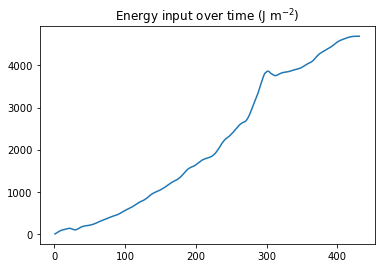

In [5]:
''' Compute wind power input (RTOFS spatial grids)'''
print('GFS ({:.1f}) time limits'.format(len(dtime_wp)),dtime_wp[0],dtime_wp[-1])
timestamp_wp = np.array([ item.timestamp() for item in dtime_wp ])
''' compute wind power (W/m^2)'''
wp = np.multiply( -UFLX_AVE, u_bp ) + np.multiply( -VFLX_AVE, v_bp )
''' mean wind power of the box (for each time) (W/m^2)'''
wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
wp_mn_box[0] = 0
''' energy intput integrated over time (J/m^2) '''
energy_wp = np.zeros( (len(timestamp_wp),) )
for t in range( len(timestamp_wp) ):
    energy_wp[t] = np.trapz( wp_mn_box[:t+1],timestamp_wp[:t+1] )
''' plot time series of energy input integrated over time '''
plt.plot(energy_wp)
plt.title('Energy input over time (J m$^{-2}$)')

In [44]:
print('wind power time series is from ',dtime_wp[0],' to ',dtime_wp[-1])
print('The total time span = ',(dtime_wp[-1]-dtime_wp[0]))

wind power time series is from  2023-09-04 00:00:00  to  2023-09-21 23:00:00
The total time span =  17 days, 23:00:00


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_54552/254444606.py:28: RuntimeWarning: Mean of empty slice
  data = np.nanmean( wp, axis=0 )


<Figure size 432x288 with 0 Axes>

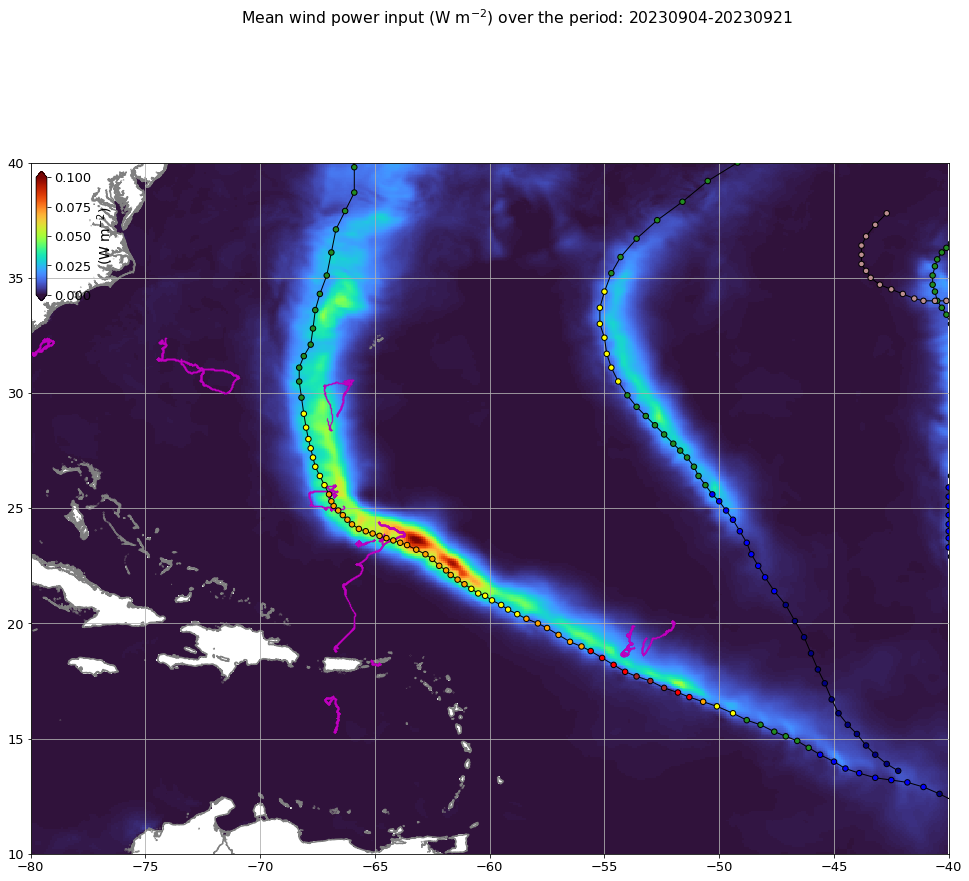

In [41]:
''' Plot TC tracks - colors in TC status. Plot one plot per year 
-5 unknown_type_XX 
-4 post_tropical_ET_EX_PT 
-3 misc_disturbances_WV_LO_DB_DS_IN_MD 
-2 subtropical_SS_SD 
-1 tropical_depression_w_lt_34 
0 tropical_storm_wind_35-63 
1 hurricane_cat_1_wind_64-82 
2 hurricane_cat_2_wind_83-95 
3 urricane_cat_3_wind_96-112 
4 hurricane_cat_4_wind_113-136 
5 hurricane_cat_5_wind_137+
'''
### plot tracks on map
ilon = np.where( lon_topo>= -100 )[0]
ilat = np.where( lat_topo>= 5 )[0]
cmap = 'turbo'
sshs = np.arange(-5,6)
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','yellow','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']
year_this_plot = '2023'
tlim_tracks = [datetime.datetime(int(year_this_plot),9,1), datetime.datetime(int(year_this_plot),9,21)]
### plot wind power stats as background
plt.clf()
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 13})
ax2 = fig.add_axes([0.05,0,0.85,0.8])
data = np.nanmean( wp, axis=0 )
cs = ax2.pcolormesh(longitude_wp, latitude_wp, data, cmap=cmap, vmin=0, vmax=0.1, zorder=0)
### plot land boundaries
ax2.contour(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], colors='gray',levels=0,zorder=1)
## plot SD tracks
vars_str = ['time','longitude','latitude']
for i, file in enumerate( fnpos ):
    ds = nc.Dataset(path_SD + file)
    ### read lon/ lat from this position file
    for v in range( len(vars_str) ):
        exec(vars_str[v]+'= ds.variables["'+vars_str[v]+'"][:]')
    dtime_this_SD = np.array([datetime.datetime(int(year_this_plot),1,1)+datetime.timedelta(seconds=dt) for dt in time])
    # _, yday = datetime_to_yearday(dtime)
    ### plot SD tracks
    year_this_file = file[14:18]
    icol = np.where( year == year_this_file )[0][0]
    if year_this_file == year_this_plot:
        it_plot = np.where( (dtime_this_SD>= tlim_tracks[0]) & (dtime_this_SD<= tlim_tracks[1]) )[0]
        ax2.scatter( longitude[it_plot], latitude[it_plot], s=0.05,c='m', zorder=2)
### plot TC tracks 
for i in range( dtime_track.shape[0] ):
    year_this_track = str(dtime_track[i,0].year)
    if (year_this_track == year_this_plot) & \
        (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
        edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
        dtime_track_ok = dtime_track[i,edge_ok[0]:edge_ok[1]+1]
        if (dtime_track_ok[0]> tlim_tracks[0]) & (dtime_track_ok[1]< tlim_tracks[1]):
            icol = np.where( year == year_this_track )[0][0]
            # edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
            lon_ok = usa_lon[i,edge_ok[0]:edge_ok[1]+1]
            lat_ok = usa_lat[i,edge_ok[0]:edge_ok[1]+1]
            sshs_ok = usa_sshs[i,edge_ok[0]:edge_ok[1]+1]
            c_sshs_ok = []
            for j in sshs_ok+5:
                c_sshs_ok.append(cols_sshs[j])
            plt.plot( lon_ok, lat_ok, '-',color='k',lw=1,zorder=3)
            sc = plt.scatter( lon_ok, lat_ok, s=30, c=c_sshs_ok, edgecolors='k', zorder=4)
### plot TC category icons
# for i, str_sshs in enumerate(strs_sshs):
#     plt.plot(-76+i*2.2, 40,'o',color=cols_sshs[i+3],ms=10)
#     plt.text(-76+i*2.2, 40.4, str_sshs,color='k',ha='center',va='bottom')
### figure settings
ax2.set_xlim([-80,-40])
ax2.set_ylim([10,40])
ax2.grid()
### add colorbar 
axf = fig.add_axes([0.055,0.64,0.01,0.15])
axf = plt.colorbar(cs,orientation='vertical',cax=axf,extend='both')
axf.set_label('(W m$^{-2}$)',fontsize=14)
### 
plt.suptitle('Mean wind power input (W m$^{-2}$) over the period: '+tlim_str)
### save figure
fig.savefig('map_wp_SD-tracks_TC-tracks_'+tlim_str+'_'+xylim_str+'.png', dpi=600,bbox_inches='tight')

The total area of the box is 1.403E+13 m^2 = 1.4E+07 km^2
This box input 4.280E-02 TW of power


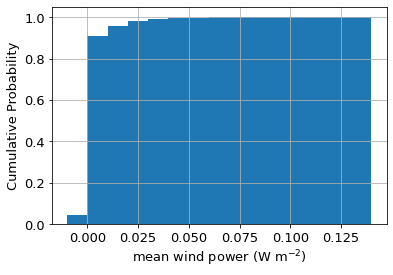

In [33]:
''' plot histogram of the temporal mean wind power (W / m^2) over the period in the x-y domain '''
plt.clf()
plt.hist(data.flatten(),np.arange(-0.01,0.15,0.01),cumulative=True,density=True);
plt.grid()
plt.xlabel('mean wind power (W m$^{-2}$)')
plt.ylabel('Cumulative Probability')
plt.savefig('hist-cum-wp(NI{:.2f}f-{:.2f}f)_'+tlim_str+'_'+xylim_str+'.png', dpi=600,bbox_inches='tight')

''' compute the total area of the ocean grid box and total wind power input of in the x-y domain (W) '''
wp_mn = data
area_m2_total = 0
wp_total = 0
for i in range( len(longitude_wp)-1 ):
    for j in range( len(latitude_wp)-1 ):
        if np.isnan( wp_mn[j,i] ) == 0: # only account for ocean grids
            obj = {'type':'Polygon','coordinates':[[[longitude_wp[i],latitude_wp[j]],[longitude_wp[i],latitude_wp[j+1]],\
                                                    [longitude_wp[i+1],latitude_wp[j+1]],[longitude_wp[i+1],latitude_wp[j]],[longitude_wp[i],latitude_wp[j]]]]}
            area_m2 = area(obj)
            # print(area_m2)
            area_m2_total = area_m2_total + area_m2
            wp_total = wp_total + wp_mn[j,i]*area_m2
            # break
print('The total area of the box is {:.3E} m^2 = {:.1E} km^2'.format(area_m2_total,area_m2_total*1e-6))
print('This box input {:.3E} TW of power'.format(wp_total*1e-12))

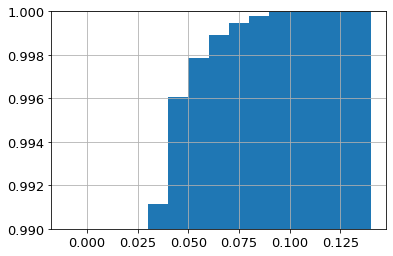

In [39]:
plt.hist(data.flatten(),np.arange(-0.01,0.15,0.01),cumulative=True,density=True);
plt.ylim([0.99,1])
plt.grid()